In [1]:
import sys, os
import networkx as nx
import matplotlib.pyplot as plt
from stackapi import StackAPI
from bs4 import BeautifulSoup

sys.path.append(os.path.abspath("../../../src/"))
from helper.convmanager import *
from helper.stack_utils import *
from helper.utils import *

#### Utility Functions

In [2]:
site = StackAPI('stackoverflow')

questions_url = 'questions'
answers_to    = 'questions/%s/answers'
comments_to   = 'answers/%s/comments'

#### Get questions

In [3]:
site.page_size = 2     # get only 2 questions
site.max_pages = 1     # for each request (one in this case)

questions = get_questions(num_questions=1, site=site)

#### Build the graph

In [4]:
%%time

site.page_size = 30
site.max_pages = 1

Graph = nx.DiGraph()

for question in questions['items'][:1]:
    question_user_id = get_user_id(question)
    question_id      = get_question_id(question)
    q_sentiment = get_sentiment(get_text(question))
    
    Graph.add_node(question_user_id)
    answers = get_answers(question_id, site=site)
    
    for answer in answers['items']:
        answer_user_id = get_user_id(answer)
        answer_id      = get_answer_id(answer)
        
        # compute the weight of the edge (answer, question)
        a_sentiment   = get_sentiment(get_text(answer))
        aq_sentiment  = get_sentiment_score(a_sentiment, q_sentiment)
        aq_similarity = get_similarity(get_text(answer), get_text(question)) # Graph.add_node(answer_id)
        aq_weight     = get_weight(aq_sentiment, aq_similarity)
        
        Graph.add_edge(answer_user_id, question_user_id, weight=aq_weight)
        comments = get_comments(answer_id, site=site)
        
        for comment in comments['items']:
            comment_user_id = get_user_id(comment)
            comment_id      = get_comment_id(comment)
            
            # compute the weight of the edge (comment, answer)
            c_sentiment   = get_sentiment(get_text(comment))
            ca_sentiment  = get_sentiment_score(c_sentiment, a_sentiment)
            ca_similarity = get_similarity(get_text(comment), get_text(answer))
            ca_weight     = get_weight(ca_sentiment, ca_similarity)
            
            Graph.add_edge(comment_user_id, answer_user_id, weight=ca_weight)

CPU times: user 789 ms, sys: 41.7 ms, total: 830 ms
Wall time: 13.8 s


### Draw the graph

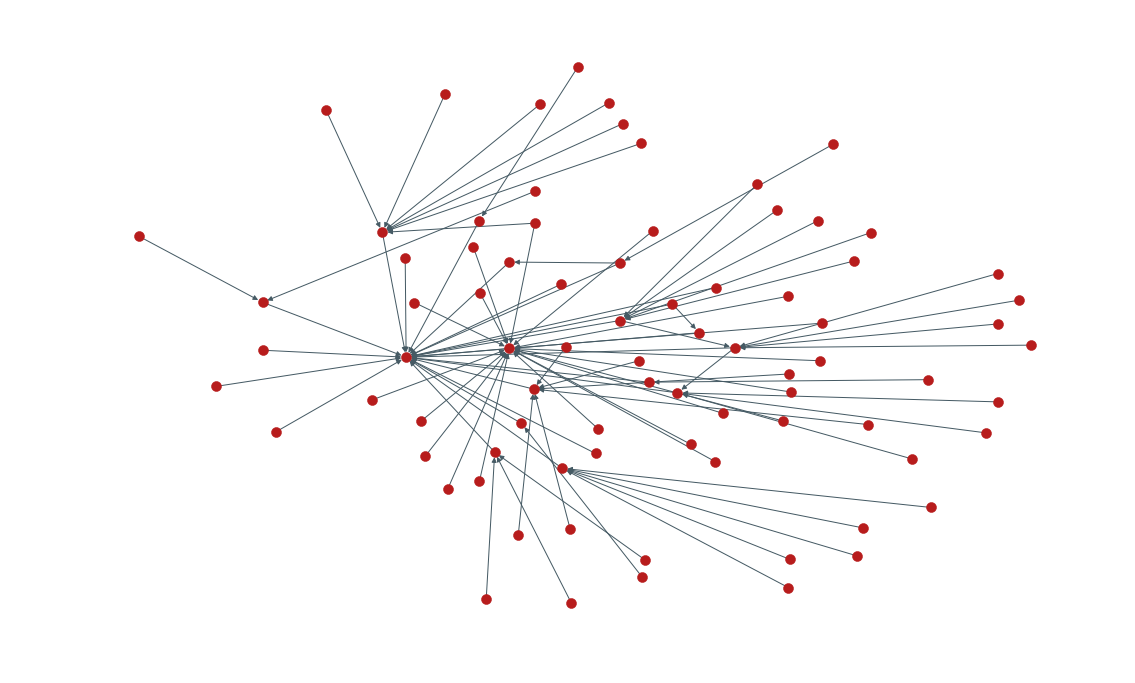

In [5]:
plt.rcParams["figure.figsize"] = [15, 9]
plt.style.use('ggplot')

pos = nx.spring_layout(Graph)
edge_labels = nx.get_edge_attributes(Graph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 100,
    'width': 1
}

nx.draw(Graph, pos, **draw_options)
# nx.draw_networkx_edge_labels(Graph, pos, edge_labels=edge_labels, font_color='#006064');